**Name:**

**5/6 digits AUS ID:**

In this homework you will be exploring corner detection, feature extraction, and image matching. Few things to keep in mind.

*   The use of cv2 is highly recommended for this homework.

*   The use of AI tools is allowed but efficiency is important.

*   Please submit a pdf **AND** a zip file to ilearn. Failure to do so will result in a 2 points deduction.

*   Please add your name and AUS id to the file in the first cell. Failure to do so will result in 4 points deduction.

*   A late penalty of 10 points per day will be applied.

*  For inquires please email asajun@aus.edu


Have fun 👍



---






### **Introduction:**

This section is a summary of few key terms from the lectures that are neccessary for this assessment. If you are comfortable with it feel free to move on to the first question.

<html>
<img src = https://docs.opencv.org/4.x/feature_building.jpg>
</html>

**What are features?**

Imagine that you are playing a jigsaw puzzle. Typically, you would look up for pieces with notable features that are easy for you to localize in the puzzle. Now let us assume that you were given the six pieces labelled from A to F in the image above. You are asked to specify its location in the image. In this case we would have the following:


*   A and B are flat surfaces and they are spread over a lot of area. It is difficult to find the exact location of these patches.
*   C and D are much more simple. They are edges of the building. You can find an approximate location, but exact location is still difficult. This is because the pattern is same everywhere along the edge. At the edge, however, it is different. An edge is therefore better feature compared to flat area, but not good enough (It is good in jigsaw puzzle for comparing continuity of edges).
*  Finally, E and F are some corners of the building. And they can be easily found. Because at the corners, wherever you move this patch, it will look different. So they can be considered as good features.


**So how do we find these features?**

We basically look for the regions in the image which have maximum variation when moved (by a small amount) in all regions around it. We call this process ***Feature Detection.*** Once you have found the features, you should be able to find the same in the other images as well. How is this done? We take a region around the feature, we explain it in our own words, like "upper part is blue sky, lower part is region from a building, on that building there is glass etc" and you search for the same area in the other images. Basically, you are describing the feature. Similarly, a computer also should describe the region around the feature so that it can find it in other images. We call this description ***Feature Description***.

Once you have the features and its description, you can find same features in all images and align them, stitch them together or do whatever you want.

Sounds good? Now let us do it using code!



---



**Q.1. Corner Detection [/20]**

1.1. Corner Detection is critical to extract good features. The first attempt to detect corners using a computer was that introduced by Chris Harris & Mike Stephens in 1988 and was named after the first hence the Harris Detector (poor Stephans...). Harris Detector tries to maximize the intensity difference per shift in order to detect a corner. This can be formulated as the following:

$$
E(u, v) = \sum_{x, y} w(x, y) \left[ I(x+u, y+v) - I(x, y) \right]^2
$$


Don't worry. In reality this is much simpler than what it looks like.

First, we need to find the sobel on x "$Ix$" and the sobel on y "$Iy$" derivatives. Compute the Sobel x and y gradients of AUS logo (AUS.png). Stick to the template provided. [/3]

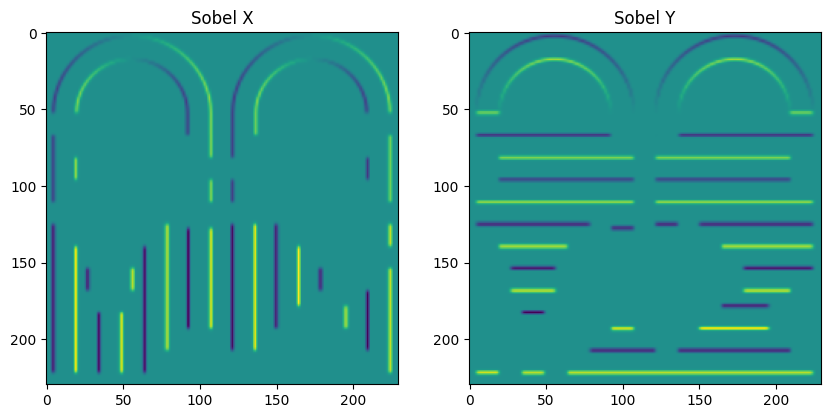

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Read the image
image = cv2.imread("/content/AUS.png")

#convert the image to grayscale
# 1 point
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Compute gradients using Sobel operators (use a kernel of 3)
# 2 points

I_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
I_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

# Plot Sobel x and Sobel y
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(I_x)
plt.title('Sobel X')

plt.subplot(1, 2, 2)
plt.imshow(I_y)
plt.title('Sobel Y')

plt.show()

Now we need to compute the Harris Matrix components which are shown below. [/3]
$$
H = \begin{bmatrix}
\sum_{i,j} I_x^2 & \sum_{i,j} I_x  I_y \\
\sum_{i,j} I_x  I_y & \sum_{i,j} I_y^2
\end{bmatrix}
$$


In [ ]:
# Compute components of the Harris Matrix (3 points)
k_size = 5
I_x_squared = cv2.GaussianBlur(I_x ** 2, (k_size, k_size), 0)
I_y_squared = cv2.GaussianBlur(I_y ** 2, (k_size, k_size), 0)
I_x_y = cv2.GaussianBlur(I_x * I_y, (k_size, k_size), 0)

Now we calculate the response. [/6]
$$
R = Det(H) - k*tr(H)^2
$$

where

$$
Det(H) = Ix^2Iy^2 - (IxIy)^2
$$

$$
tr(H) = Ix^2 + Iy^2
$$

In [ ]:
# Compute the Harris corner response (6 points)
# k = 0.04
k = 0.04
det_H = I_x_squared * I_y_squared - I_x_y**2
trace_H = I_x_squared + I_y_squared
harris_response = det_H - k * trace_H**2

Finally, we see the keypoints detected.

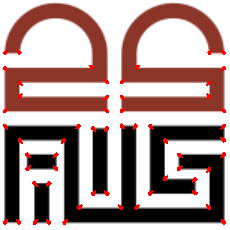

In [ ]:
#harris response contrains a value for every pixel.
#for that we are picking the points with a response greater than
#a threshold (0.001) of the max value only.
from google.colab.patches import cv2_imshow

#[0,0,255] changes the points color to red

image[harris_response > 0.001 * harris_response.max()] = [0, 0, 255]
cv2_imshow(image)

Use "cornerHarris" function in cv2 to verify your answer. [/6]

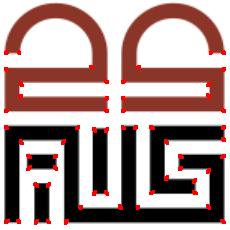

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread("/content/AUS.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray, blockSize=2, ksize=5, k=0.04)
dst = cv2.dilate(dst, None)
img[dst>0.001*dst.max()]=[0, 0, 255]

cv2_imshow(img)

How does the variable $k$ influence your output? [/2]

**Ans:** The k parameter lets you influence precision and recall. With a bigger k, you will get less false corners but you will also miss more real corners (high precision), with a smaller k you will get a lot more corners, so you will miss less true corners, but get a lot of false ones (high recall).



---
**Q.2. SIFT [/30]**

One major issue in harris corner detector is that it fails to detect the same features if the image was rescaled to a different size (See below).

<html>
<img src=https://miro.medium.com/v2/resize:fit:1400/1*wfgQ600MfwD36lb7u-ka8g.png width="480" height="300">
</html>

In order to mitigate this issue, Scale Invariant Feature Transform (SIFT) was introduced by D. Lowa in 2004. SIFT is quite simple yet superior to Harris detector.

SIFT uses the Difference in Gaussians (DoG) concept. What this essentially means is that we will first apply a gaussian blur to an image $n$ times (ideally 5) where we increase the blurring sigma by double (ideally starting from sigma 1.6). Then we will find the result of subtracting each two consecutive images.

<html>
<img src=https://av-eks-blogoptimized.s3.amazonaws.com/Screenshot-from-2019-09-25-14-18-26.png>
</html>

As we can see, this enhances the features detected. Later on we downsample the image (make it smaller) and repeat the same process. We call every set of $n$ blurred images an *octave*. We repeat this process for $m$ times (ideally 4). This allows SIFT to be **scale invariant**.

<html>
<img src=https://av-eks-blogoptimized.s3.amazonaws.com/Screenshot-from-2019-09-24-18-27-46.png>
</html>

In Q2. Folder, pick the Monalisa that corresponds to your id. You may run the following cell to obtain the image easily. Make sure to show the output of this cell in your submission as this letter is to be used throughout this assignment.

In [ ]:
# @title Run this cell
id = input("Enter your id: ")
im = int(id) % 3
if(im == 0): print("Use Monalisa_A")
elif(im==1): print("Use Monalisa_B")
else: print("Use Monalisa_C")

Enter your id: 86137
Use Monalisa_B


2.1. Apply Gaussian Blur (ksize = 17) to the image assigned to you 5 times and display the results at each iteration. Start with an initial sigma value of 1.6. Use a grayscale image to reduce computations. [/6]

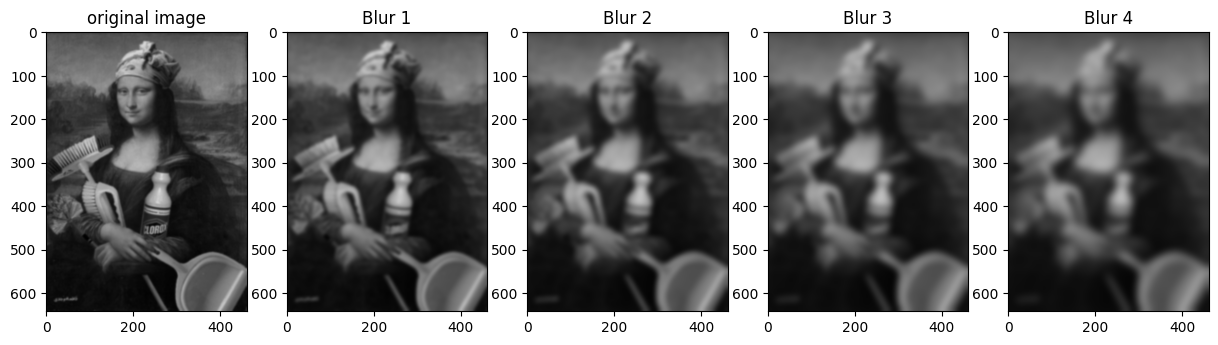

In [ ]:
img = cv.imread('/content/Monalisa_B.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imgs = []
sigma = 1.6

plt.figure(figsize=(15, 8))

for i in range(5):
  imgs.append(img)

  #correct filter (2 points)
  img = cv.GaussianBlur(img, (17,17), sigma, sigma)

  #increment (2 points)
  sigma = sigma * 2

  # Plot the blurred images (2 points)
  plt.subplot(1, 5, i + 1)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap='gray')
  if i == 0:
    plt.title("original image")
  else:
    plt.title(f'Blur {i}')

plt.show()

2.2. Find the DoGs of the first octave that you just found (cmap=gray) [/5]

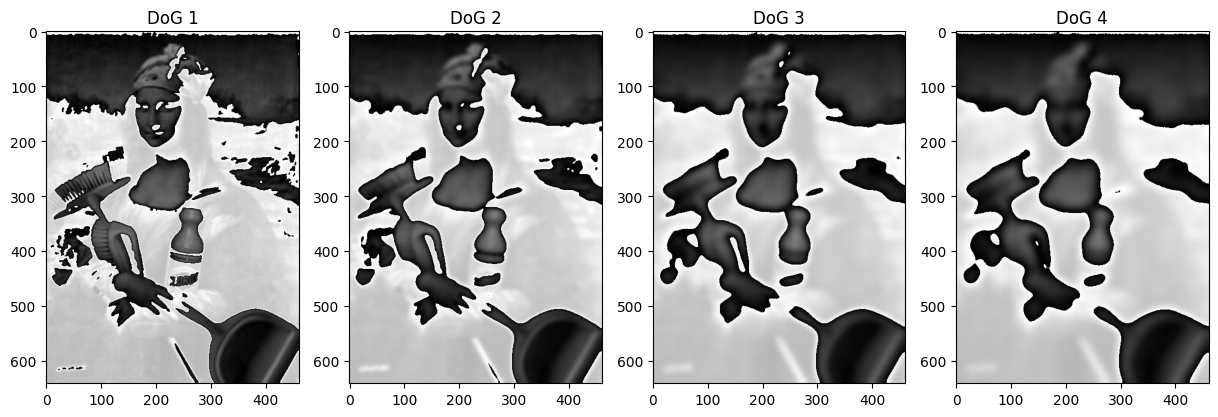

In [ ]:
DoGs = []

plt.figure(figsize=(15, 8))

#correct DOG calculation (2 points)
for i in range(4):
  DoG = imgs[i+1] - img[i]
  DoGs.append(DoG)

    # Plot the blurred image (3 points)
  plt.subplot(1, 4, i + 1)
  plt.imshow(cv2.cvtColor(DoG, cv2.COLOR_BGR2RGB), cmap='gray')
  plt.title(f'DoG {i + 1}')

plt.show()

2.3. Find the same results for the second octave. [/4]

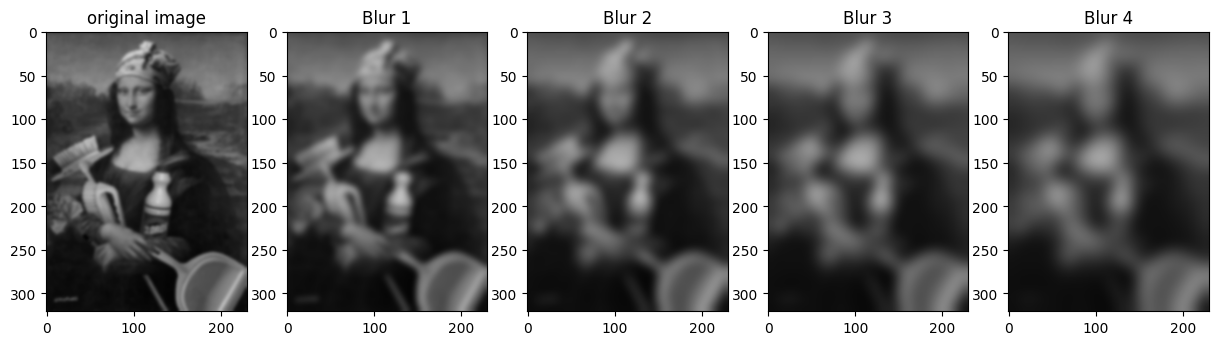

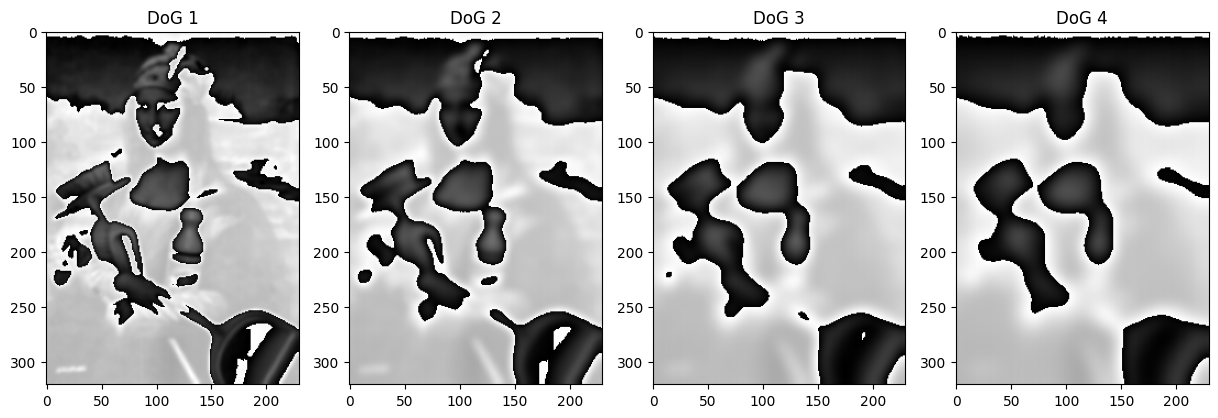

In [ ]:
img = cv.imread('/content/Monalisa_B.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (0, 0), fx=0.5, fy=0.5) #3 points
imgs = []
sigma = 1.6

plt.figure(figsize=(15, 8))

for i in range(5):
  imgs.append(img)
  img = cv.GaussianBlur(img, (17,17), sigma, sigma)
  sigma = sigma * 2

  # Plot the blurred image
  plt.subplot(1, 5, i + 1)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap='gray')
  if i == 0:
    plt.title("original image")
  else:
    plt.title(f'Blur {i}')

plt.show()

DoGs = []

plt.figure(figsize=(15, 8))

for i in range(4):
  DoG = imgs[i+1] - img[i]
  DoGs.append(DoG)

    # Plot the blurred image
  plt.subplot(1, 4, i + 1)
  plt.imshow(cv2.cvtColor(DoG, cv2.COLOR_BGR2RGB), cmap='gray')
  plt.title(f'DoG {i + 1}')

#1 point
plt.show()

What happens next is that we need to find the keypoints. This is achieved by finding the pixel local maxima and minima for these images. A pixel is considered a keypoint if it has the maximum value with respect to the surrounding 8 pixels and to the same point in the image before it and after it within the same octave. In the figure below $x$ is our pixel of interest and the 26 green dots are those it is compared to.

<html>
<img src = https://av-eks-blogoptimized.s3.amazonaws.com/Screenshot-from-2019-09-25-16-50-01-300x207.png>
</html>

From here onwards we will be using cv2 SIFT function to find these keypoints.

2.4. Use cv2 to detect 50 keypoints in your image. Keep it in grayscale and do not use any flag. [/5]

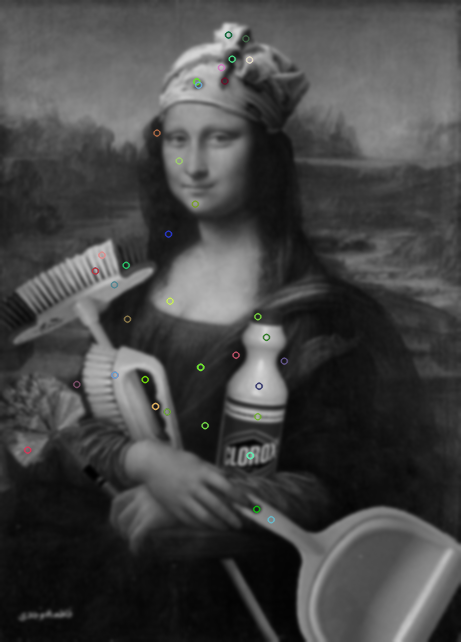

In [ ]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow

#refer to this link for sift implementation
#https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html

#DO NOT USE any flag!

#same params (2 points)
img = cv.imread('/content/Monalisa_B.jpg')
img = cv.GaussianBlur(img, (17,17), 1.6)
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)

#correct points (1 point)
sift = cv.SIFT_create(50)
kp = sift.detect(gray,None)

#correct drawing (no flags) (2 points)
img=cv.drawKeypoints(gray,kp,img)
cv2_imshow(img)

Now we have our keypoints, we need to describe them. For this, we need to obtain the orientation of each point to make it rotation invariant. Finding the orientation of these points is simple.

<html>
<img src=https://av-eks-blogoptimized.s3.amazonaws.com/Screenshot-from-2019-09-25-19-22-24.png>
</html>

Let us assume that our keypoint is the red highlighted pixel in the image above. We need to find the gradient in x and y directions for this pixel before finding the angle.

$Gx = 55 - 46 = 9$

$Gy = 56 - 42 = 14$

$A = sqrt(9^2 +14^2) = 16.64 $

$θ = arctan(14/9) = 57.17°$


2.5. Find the magnitude and orientation of the point that corresponds to your Monalisa (A, B, or C) in the figure below. [/5]

<html>
<img src="https://i.ibb.co/SDjX3zx/Screenshot-2024-02-24-193642.png">
</html>

In [ ]:
#Solving for B
import math
#2 points
Gx = 46 - 40
Gy = 50 - 41

#3 points
A = np.sqrt(Gx**2 + Gy**2)
result = math.atan(Gy/Gx)
theta = math.degrees(result)
print("Magnitude = ", A, ", Orientation = ", theta)

Magnitude =  10.816653826391969 , Orientation =  56.309932474020215


2.6. Use cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS flag to see the magnitude and orientation of your image. [/5]

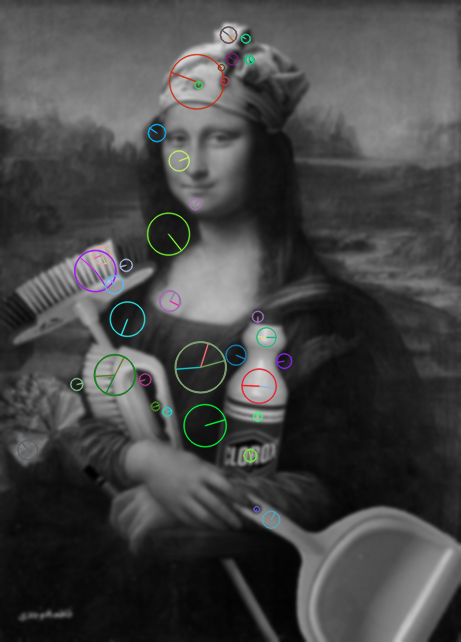

In [ ]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow

img = cv.imread('/content/Monalisa_B.jpg')

#using the same params (2 points)

img = cv.GaussianBlur(img, (17,17), 1.6)
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)

#correct number (1 point)
sift = cv.SIFT_create(50)

#correct plotting and flags (1 point)
kp = sift.detect(gray,None)
img=cv.drawKeypoints(gray,kp,img,
                     flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2_imshow(img)

**Q.3. Image Matching [/20]**

In order to match two images, we need to calculate the keypoints of these two images along with their descriptors. To do so, one can directly utilize openCV as following

```
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp, des = sift.detectAndCompute(img,None)
```

Calculate the keypoints and descriptors for the original monalisa (Monaliza_original.jpg) and your own version of it (A, B, or C). Resize your image to the size of the original Monaliza before computing. [/10]

In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

#reading (2 points)
#resizing (2 points)
#extracting kps and deses (6 points)

img1 = cv.imread('/content/Monalisa_Original.jpg',cv.IMREAD_GRAYSCALE)
img2 = cv.imread('/content/Monalisa_A.jpg',cv.IMREAD_GRAYSCALE)
img2 = cv.resize(img2, (1200, 1788))
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

Use cv.BFMatcher to match the two images using knn (k=2). As the number of points may be big. Use the code below to filter out the good keypoints only.

```
# the array "good" stores the wanted matches

good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
```

Draw a conclusion on your results. [/10]





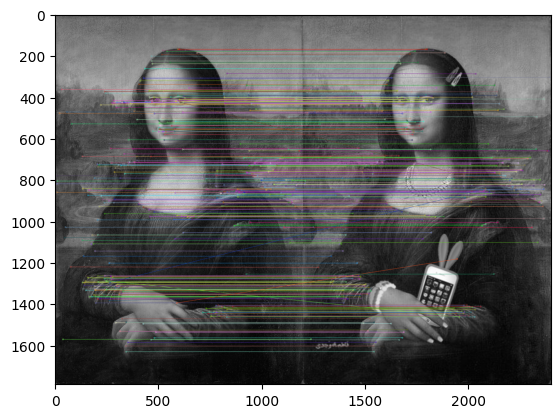

(<matplotlib.image.AxesImage at 0x7d0b4b053310>, None)

In [ ]:
# BFMatcher with default params
# correct initalization (2 points)

bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

#extraction (3 points)

good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

#drawing (3 points)

img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,
                         flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

#results and conclusion (2 points)

plt.imshow(img3),
plt.show()

**ANS:** looks good :D

Q.4. RANSAC [/30]

for this question, you will need the following libraries. Please import them.

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm.notebook import tqdm
plt.rcParams['figure.figsize'] = [15, 15]

Stitching is a task in which two images of the same object are taken from different angles are combined into one. In fact, it was what your phone technically do when you take a panorama image. In Q.4. folder, you will find pair of images for some books labelled with your assigned letter (A, B, or C). You are requierd to use SIFT and RANSAC to stitch these two images. To make your life easier I have provided you with helper functions that you just need to use if you want (helper_functions.py).

4.1. Read your right and left images using the read_images function provided. Use the SIFT function to find the keypoints and descriptors needed for both images. Plot the found keypoints for both images together. [/5]

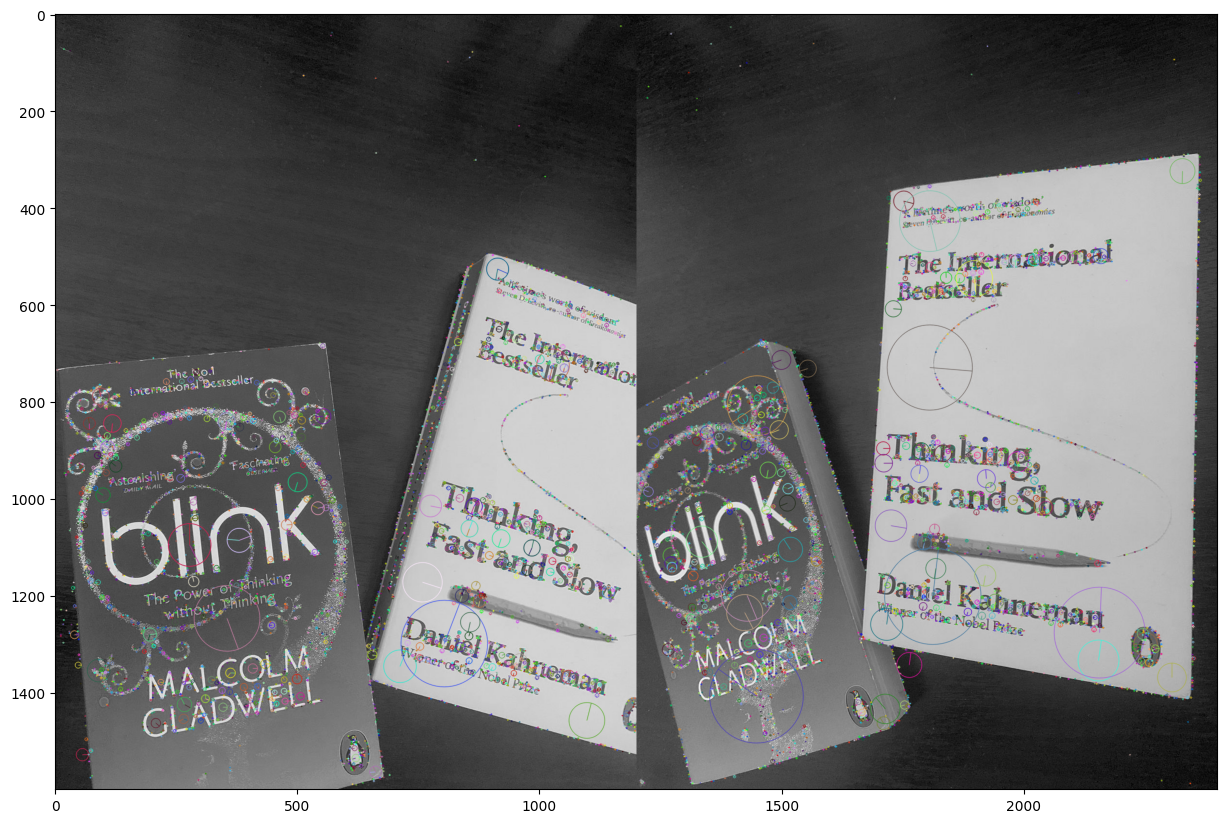

In [ ]:
def read_image(path):
    img = cv2.imread(path)
    img_gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_gray, img, img_rgb

def SIFT(img):
    siftDetector= cv2.xfeatures2d.SIFT_create() # limit 1000 points
    # siftDetector= cv2.SIFT_create()  # depends on OpenCV version

    kp, des = siftDetector.detectAndCompute(img, None)
    return kp, des

def plot_sift(gray, rgb, kp):
    tmp = rgb.copy()
    img = cv2.drawKeypoints(gray, kp, tmp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img

left_gray, left_origin, left_rgb = read_image('/content/C_L.jpeg')
right_gray, right_origin, right_rgb = read_image('/content/C_R.jpeg')

kp_left, des_left = SIFT(left_gray)
kp_right, des_right = SIFT(right_gray)

kp_left_img = plot_sift(left_gray, left_rgb, kp_left)
kp_right_img = plot_sift(right_gray, right_rgb, kp_right)
total_kp = np.concatenate((kp_left_img, kp_right_img), axis=1)
plt.imshow(total_kp)

Use the matcher function to find the matches between both images. Then use the plot_matches function to plot these matches. Use a threshold of (0.5). [/5]

In [ ]:
def matcher(kp1, des1, img1, kp2, des2, img2, threshold):
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < threshold*n.distance:
            good.append([m])

    matches = []
    for pair in good:
        matches.append(list(kp1[pair[0].queryIdx].pt + kp2[pair[0].trainIdx].pt))

    matches = np.array(matches)
    return matches

matches = matcher(kp_left, des_left, left_rgb, kp_right, des_right, right_rgb, 0.5)

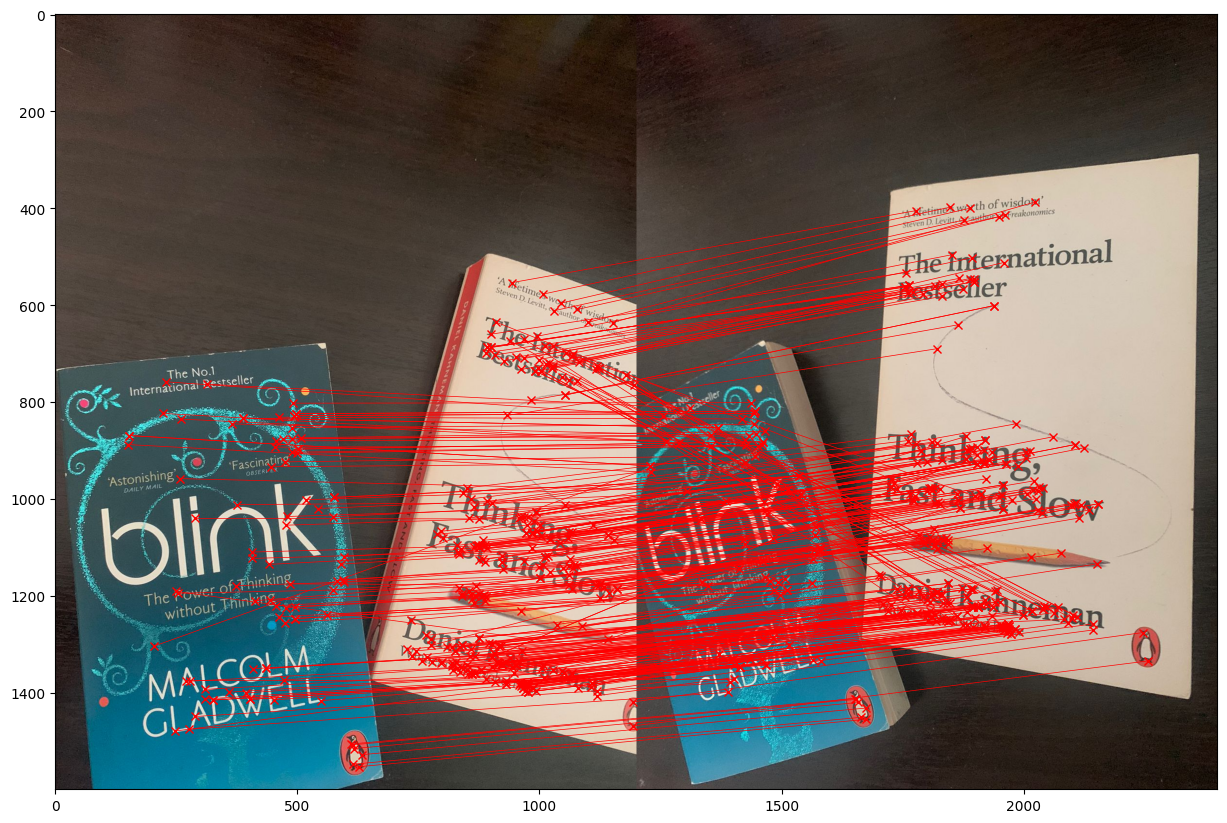

In [ ]:
def plot_matches(matches, total_img):
    match_img = total_img.copy()
    offset = total_img.shape[1]/2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(match_img).astype('uint8')) #　RGB is integer type

    ax.plot(matches[:, 0], matches[:, 1], 'xr')
    ax.plot(matches[:, 2] + offset, matches[:, 3], 'xr')

    ax.plot([matches[:, 0], matches[:, 2] + offset], [matches[:, 1], matches[:, 3]],
            'r', linewidth=0.5)

    plt.show()

total_img = np.concatenate((left_rgb, right_rgb), axis=1)
plot_matches(matches, total_img) # Good mathces

Use ransac function to find the inliers and the homography (H) needed. Make sure to add all other required functions to your code for it to run properlly (get_errors, homography, etc...). Play around with the threshold and number of iterations to get reasonably good output. Plot the matches you find using plot matches function. [/5]

In [ ]:
def homography(pairs):
    rows = []
    for i in range(pairs.shape[0]):
        p1 = np.append(pairs[i][0:2], 1)
        p2 = np.append(pairs[i][2:4], 1)
        row1 = [0, 0, 0, p1[0], p1[1], p1[2], -p2[1]*p1[0], -p2[1]*p1[1], -p2[1]*p1[2]]
        row2 = [p1[0], p1[1], p1[2], 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1], -p2[0]*p1[2]]
        rows.append(row1)
        rows.append(row2)
    rows = np.array(rows)
    U, s, V = np.linalg.svd(rows)
    H = V[-1].reshape(3, 3)
    H = H/H[2, 2] # standardize to let w*H[2,2] = 1
    return H

In [ ]:
def random_point(matches, k=4):
    idx = random.sample(range(len(matches)), k)
    point = [matches[i] for i in idx ]
    return np.array(point)

In [ ]:
def get_error(points, H):
    num_points = len(points)
    all_p1 = np.concatenate((points[:, 0:2], np.ones((num_points, 1))), axis=1)
    all_p2 = points[:, 2:4]
    estimate_p2 = np.zeros((num_points, 2))
    for i in range(num_points):
        temp = np.dot(H, all_p1[i])
        estimate_p2[i] = (temp/temp[2])[0:2] # set index 2 to 1 and slice the index 0, 1
    # Compute error
    errors = np.linalg.norm(all_p2 - estimate_p2 , axis=1) ** 2

    return errors

In [ ]:
def ransac(matches, threshold, iters):
    num_best_inliers = 0

    for i in range(iters):
        points = random_point(matches)
        H = homography(points)

        #  avoid dividing by zero
        if np.linalg.matrix_rank(H) < 3:
            continue

        errors = get_error(matches, H)
        idx = np.where(errors < threshold)[0]
        inliers = matches[idx]

        num_inliers = len(inliers)
        if num_inliers > num_best_inliers:
            best_inliers = inliers.copy()
            num_best_inliers = num_inliers
            best_H = H.copy()

    print("inliers/matches: {}/{}".format(num_best_inliers, len(matches)))
    return best_inliers, best_H

inliers/matches: 115/357


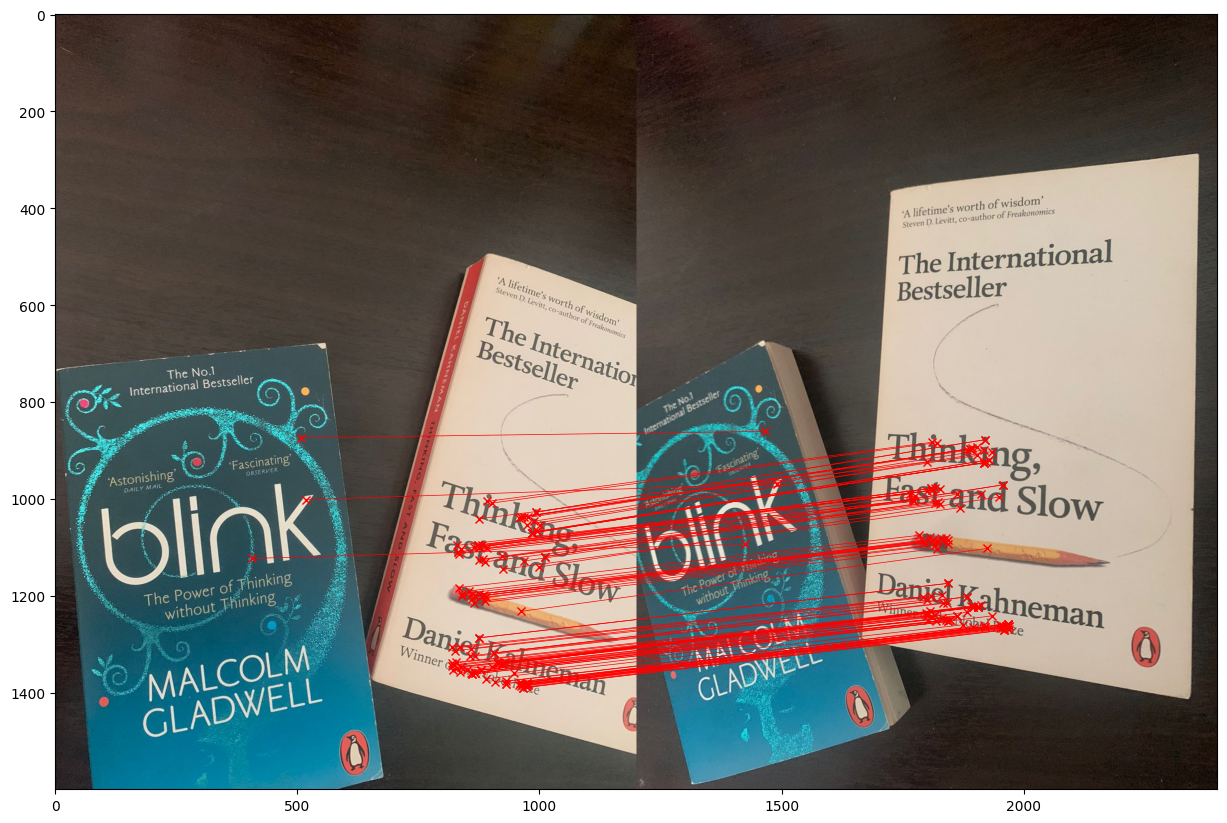

In [ ]:
inliers, H = ransac(matches, 0.5, 2000)
plot_matches(inliers, total_img) # show inliers matches

Use stitch_img function to stitch the two images. [/10]

stiching image ...


  0%|          | 0/1889 [00:00<?, ?it/s]

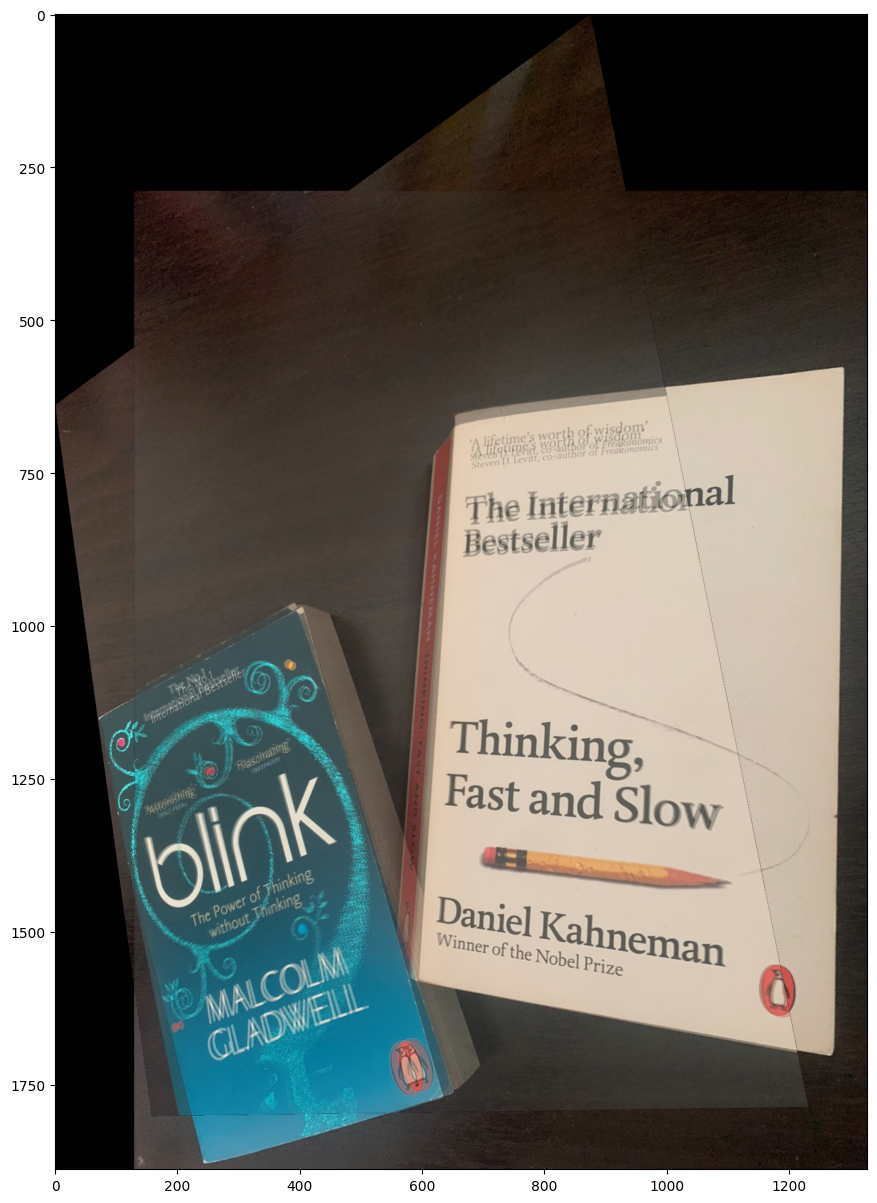

In [ ]:
def stitch_img(left, right, H):
    print("stiching image ...")

    # Convert to double and normalize. Avoid noise.
    left = cv2.normalize(left.astype('float'), None,
                            0.0, 1.0, cv2.NORM_MINMAX)
    # Convert to double and normalize.
    right = cv2.normalize(right.astype('float'), None,
                            0.0, 1.0, cv2.NORM_MINMAX)

    # left image
    height_l, width_l, channel_l = left.shape
    corners = [[0, 0, 1], [width_l, 0, 1], [width_l, height_l, 1], [0, height_l, 1]]
    corners_new = [np.dot(H, corner) for corner in corners]
    corners_new = np.array(corners_new).T
    x_news = corners_new[0] / corners_new[2]
    y_news = corners_new[1] / corners_new[2]
    y_min = min(y_news)
    x_min = min(x_news)

    translation_mat = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
    H = np.dot(translation_mat, H)

    # Get height, width
    height_new = int(round(abs(y_min) + height_l))
    width_new = int(round(abs(x_min) + width_l))
    size = (width_new, height_new)

    # right image
    warped_l = cv2.warpPerspective(src=left, M=H, dsize=size)

    height_r, width_r, channel_r = right.shape

    height_new = int(round(abs(y_min) + height_r))
    width_new = int(round(abs(x_min) + width_r))
    size = (width_new, height_new)


    warped_r = cv2.warpPerspective(src=right, M=translation_mat, dsize=size)

    black = np.zeros(3)  # Black pixel.

    # Stitching procedure, store results in warped_l.
    for i in tqdm(range(warped_r.shape[0])):
        for j in range(warped_r.shape[1]):
            pixel_l = warped_l[i, j, :]
            pixel_r = warped_r[i, j, :]

            if not np.array_equal(pixel_l, black) and np.array_equal(pixel_r, black):
                warped_l[i, j, :] = pixel_l
            elif np.array_equal(pixel_l, black) and not np.array_equal(pixel_r, black):
                warped_l[i, j, :] = pixel_r
            elif not np.array_equal(pixel_l, black) and not np.array_equal(pixel_r, black):
                warped_l[i, j, :] = (pixel_l + pixel_r) / 2
            else:
                pass

    stitch_image = warped_l[:warped_r.shape[0], :warped_r.shape[1], :]
    return stitch_image

plt.imshow(stitch_img(left_rgb, right_rgb, H))

 Comment on your findings. Specifically address the following points. [/5]



1.   Did all books get stitched correctly? Explain why this happened clearly.
2.   How can we imporve these results?



ANS: the students are expected to point out why one book is stitched correctly while the other isn't. The students are expected to name one or two alternatives to ransac that take into consideration different measures other than distance to match points.